In [1]:
from google.colab import files, drive
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import *
import zipfile
from tensorflow import keras
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#you need to create your own API first in kaggle
#upload kaggle json

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alhasanmusthafaa","key":"64853a0a23e1b8bfbd2bfc7b3e1f9727"}'}

In [3]:
#create a kaggle folder
!mkdir ~/.kaggle


In [4]:
#copy kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d preatcher/standard-ocr-dataset

 89% 41.0M/46.2M [00:00<00:00, 63.7MB/s]
100% 46.2M/46.2M [00:00<00:00, 66.7MB/s]


In [6]:
test_local_zip = '/content/standard-ocr-dataset.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/dataset')

zip_ref.close()

In [7]:
os.listdir('/tmp/dataset')

['data', 'data2']

In [8]:
source_dir = '/tmp/dataset/data'
os.listdir(source_dir)
     
    

['training_data', 'testing_data']

In [9]:
training_data_dir = os.path.join(source_dir, 'training_data')
validation_data_dir = os.path.join(source_dir, 'testing_data')

In [10]:
print('len of folders in training data dir: {}'.format(len(os.listdir(training_data_dir))))
print('len of folders in validation data dir: {}'.format(len(os.listdir(validation_data_dir))))

len of folders in training data dir: 36
len of folders in validation data dir: 36


In [11]:
k = os.listdir(training_data_dir)[0]
k = os.path.join(training_data_dir, k)

In [12]:
print(k)

/tmp/dataset/data/training_data/K


In [13]:
k_img = []
for index in range (len(k)):
  img = cv2.imread(os.path.join(k, os.listdir(k)[index]))
  k_img.append(img)

In [14]:
k_img[0].shape

(38, 23, 3)

In [15]:
# ret,thresh1 = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)
# kernel = np.ones((5,5),np.uint8)
# dilated = cv2.dilate(thresh1,kernel,iterations = 2)
# _,contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# cordinates = []
# for cnt in contours:
#     x,y,w,h = cv2.boundingRect(cnt)
#     cordinates.append((x,y,w,h))
#     #bound the images
#     cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)

# cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
# cv2.imwrite('content/BindingBox4.jpg',im)

In [16]:
img_size = 128
input_shape = (128,128,1)

In [17]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

training_generator = train_datagen.flow_from_directory(training_data_dir,
                                                 target_size = (img_size, img_size),
                                                 batch_size = 382,  # 20628 // 54 = 382
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical',
    
)

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                 target_size = (img_size, img_size),
                                                 batch_size = 36, #1008 // 28 = 36 
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical',
    
)

Found 20628 images belonging to 36 classes.
Found 1008 images belonging to 36 classes.


In [18]:
#make a model

# callback = EarlyStopping(monitor = 'val_loss',
#                         patience = 3,
#                         verbose = 1) 


model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32,(5,5), activation ='relu', input_shape=input_shape), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(36, activation='softmax'),



])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [19]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(training_generator,
                            steps_per_epoch = 50,
                            epochs = 100,
                            validation_data = validation_generator,
                            validation_steps = 28,
                            verbose = 1)

Epoch 1/100
50/50 [==============================] - 38s 719ms/step - loss: 0.0876 - accuracy: 0.9690 - val_loss: 0.0267 - val_accuracy: 0.9851
Epoch 2/100
50/50 [==============================] - 37s 731ms/step - loss: 0.0869 - accuracy: 0.9679 - val_loss: 0.0246 - val_accuracy: 0.9921
Epoch 3/100
50/50 [==============================] - 35s 698ms/step - loss: 0.0940 - accuracy: 0.9663 - val_loss: 0.0397 - val_accuracy: 0.9782
Epoch 4/100
50/50 [==============================] - 35s 696ms/step - loss: 0.0857 - accuracy: 0.9686 - val_loss: 0.0315 - val_accuracy: 0.9782
Epoch 5/100
50/50 [==============================] - 35s 699ms/step - loss: 0.0902 - accuracy: 0.9672 - val_loss: 0.0240 - val_accuracy: 0.9911
Epoch 6/100
50/50 [==============================] - 35s 699ms/step - loss: 0.0888 - accuracy: 0.9670 - val_loss: 0.0228 - val_accuracy: 0.9911
Epoch 7/100
50/50 [==============================] - 35s 685ms/step - loss: 0.0888 - accuracy: 0.9667 - val_loss: 0.0208 - val_accuracy:

In [63]:
!mkdir -p ocr_model
model.save('/content/model/ocr-model-al-02.h5')

In [64]:
# my_model directory
!ls ocr_model

# # Contains an assets folder, saved_model.pb, and variables folder.
# !ls saved_model/my_model

In [65]:
model = tf.keras.models.load_model('/content/model/ocr-model-al-02.h5')

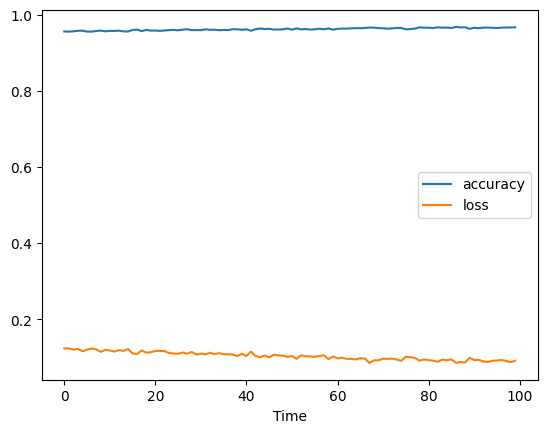

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Time')
plt.legend(['accuracy', 'loss'])
plt.show()

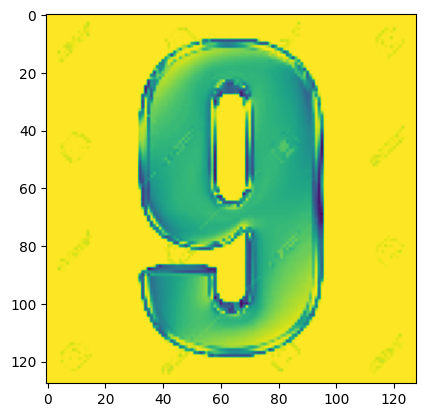

1/1 [==============================] - 0s 30ms/step

predict: Z


In [102]:
img = cv2.imread("/content/image/number/9.png")
img = cv2.resize(img, (128,128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()

img = np.array(img, dtype = 'float32')
img = np.expand_dims(img, axis = 2)
img = img.reshape(-1, 128, 128, 1)
prediction = model.predict(img)
np.argmax(prediction)

labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
print("\npredict: {}".format(labelNames[np.argmax(prediction)]))